In [1]:
import sys
# import pyccl as ccl#
import pickle
import camb
import matplotlib.pyplot as plt
sys.path.insert(0,'/home/tkarim/SkyLens/') #path to skylens
sys.path.insert(0,'/home/tkarim/SkyLens/skylens/') #path to skylens
# from importlib import reload

In [2]:
#setting up virtual dask cluster for calculations. Adjust memory and threads according to your system.
from distributed import LocalCluster
from dask.distributed import Client 
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='150gb',threads_per_worker=4,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [3]:
from skylens import *
from survey_utils import *

In [4]:
#only for python3
import importlib
reload=importlib.reload

In [5]:
wigner_files={} #FIXME: run Gen_wig_m0.py to generate these files and then pass their path here. These are large files, make sure they are not included in git.
# In file names l3500 refers to ell_max for which wigner function was calculated. It should be same or larger than ell_max in your measurements. 
# |w2100 is the max ell for window. This should be atleast 2 X ell_max in the measurements.
wigner_files[0]= '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'

# wigner_files[2]= '/Users/Deep/dask_temp/dask_wig3j_l3500_w2100_2_reorder.zarr' #everything is spin 0, should not require this. if needed, compute using Gen_wig_m2.py



# Power Spectrum covariance

In [6]:
#set cosmology
cosmo_params = {'h': 0.6736,
 'Omb': 0.04930,
 'Omd': 0.26447,
 's8': 0.817,
 'Om': 0.31377,
 'Ase9': 2.083,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.9649,
 'w': -1,
 'wa': 0,
 'Oml': 0.68623}

In [81]:
test = False

if test:
    NSIDE = 256
    lmax_cl = 256
    binsize = 10
else:
    NSIDE = 1024
    lmax_cl = 1024
    binsize = 100

In [82]:
#setup parameters
#FIXME: Check all the values below.
#lmax_cl=1024 #min and max for ell
lmin_cl=100
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl, lmax_cl, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0
# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if computation is too heavy and we want to use fewer ell

do_cov=False # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=True #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
window_lmax=2*lmax_cl #smaller value for testing. This should be 2X ell_max in the measurements.

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [83]:
def cmb_bins_here(zs=1090,l=None,use_window=use_window,unit_win=False,nside=1024,zmax=2.45):
    """
    unit_win = boolean mask 
    nside = 2048; same as sims
    This function prepares the cmb lensing data into format required for input into skylens for theory predictions.
    """
    zs_bins={}
    zs_bins[0]={}

    zs_bins=zbin_pz_norm(zs_bins=zs_bins,bin_indx=0,zs=np.atleast_1d(zs),p_zs=np.atleast_1d(1),
                         ns=0,bg1=1)
    zs_bins['n_bins']=1 #easy to remember the counts
    zs_bins['zmax']=np.atleast_1d([zmax])
    zs_bins['zp_sigma']=0
    zs_bins['zp_bias']=0
    zs_bins['nz']=1

    SN_read=np.genfromtxt('/mnt/store1/tkarim/cmb_lensing/data/MV/nlkk.dat',
                          names=('l','nl','nl2')) 
    SN_intp=interp1d(SN_read['l'],SN_read['nl'],bounds_error=False, fill_value=0)      #FIXME: make sure using the correct noise power spectra.
    SN=SN_intp(l)
    SN *= 0 #DON'T DO THIS WHEN USING REAL DATA
#     SN=np.ones_like(l)
    zs_bins['SN']={}
    zs_bins['SN']['kappa']=SN.reshape(len(SN),1,1)
    if use_window:
        zs_bins=set_window(zs_bins=zs_bins,nside=nside, unit_win=unit_win,cmb=True)
    return zs_bins

In [10]:
def set_window(zs_bins={},nside=1024,mask=None,window_cl_fact=None,unit_win=False,cmb=False):
    """
        This function sets the window functions for the datasets. These windows are necessary for converting cl to pseudo-cl.
    """
    #FIXME: make sure nside, etc. are properly matched. if possible, use same nside for cmb and galaxy maps. Use ud_grade where necessary.
    for i in np.arange(zs_bins['n_bins']):
        if unit_win:
            cl_map=hp.ma(np.ones(12*nside*nside))
            cl_i=1
        elif cmb:
            #cl_map=np.load('/mnt/store1/tkarim/mask_2048.fits') #FIXME: add the CMB lensing window here.
            cl_map=np.load('/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy')
            noise_map = cl_map
            #mask = cl_map
        else:
            #cl_map=np.load('/mnt/store1/tkarim/cmb_lensing/data/dr8/elg_ran1024.npy') #randoms are the window function.
            cl_map=np.load('/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy') #randoms are the window function.
            noise_map = np.sqrt(cl_map)
        cl_map = cl_map.astype(np.float64)
        cl_map=hp.ma(cl_map)
        noise_map = hp.ma(noise_map)
#             cl_map=hp.alm2map(alms_i,nside=nside)
        if mask is None:
            mask=cl_map>0 #FIXME: input proper mask if possible
        cl_map.mask=~mask
        #cl_map.mask=np.logical_not(mask) #same as previous line but for fits files via healpy
        noise_map.mask=~mask
        cl_map[cl_map<0]=0
        cl_map/=cl_map[mask].mean()
        cl_map_noise=np.sqrt(cl_map)
        cl_map[~mask]=hp.UNSEEN
        cl_map_noise[~mask]=hp.UNSEEN
        # cl_map.mask=mask
        zs_bins[i]['window']=cl_map
        zs_bins[i]['window_N']=noise_map #window of noise 
        zs_bins[i]['window_alm']=hp.map2alm(cl_map)
        zs_bins[i]['window_alm_noise']=hp.map2alm(cl_map_noise)
#         zs_bins[i]['window_cl']=cl_i

    return zs_bins

In [39]:
def zbin_pz_norm(zs_bins={},bin_indx=None,zs=None,p_zs=None,ns=0,bg1=1,AI=0,
                 AI_z=0,mag_fact=0,k_max=0.3):
    """
        This function does few pre-calculations and sets some parameters for datasets that will be input into skylens
    """


    dzs=np.gradient(zs) if len(zs)>1 else 1

    if np.sum(p_zs*dzs)!=0:
        p_zs=p_zs/np.sum(p_zs*dzs)
    else:
        p_zs*=0
    nz=dzs*p_zs*ns

    i=bin_indx
    x= p_zs>-1 #1.e-10

    zs_bins[i]['z']=zs[x]
    zs_bins[i]['dz']=np.gradient(zs_bins[i]['z']) if len(zs_bins[i]['z'])>1 else 1
    zs_bins[i]['nz']=nz[x]
    zs_bins[i]['ns']=ns
    zs_bins[i]['W']=1.
    zs_bins[i]['pz']=p_zs[x]*zs_bins[i]['W']
    zs_bins[i]['pzdz']=zs_bins[i]['pz']*zs_bins[i]['dz']
    zs_bins[i]['Norm']=np.sum(zs_bins[i]['pzdz'])
    zs_bins[i]['b1']=bg1 # FIXME: this is the linear galaxy bias. Input proper values. We can also talk about adding other bias models if needed.
    zs_bins[i]['bz1'] = None
    zs_bins[i]['AI']=AI # this will be zero
    zs_bins[i]['AI_z']=AI_z
    zs_bins[i]['mag_fact']=mag_fact  #FIXME: You need to figure out the magnification bias prefactor. For example, see appendix B of https://arxiv.org/pdf/1803.08915.pdf
    zs_bins[i]['shear_m_bias']=1
    zm=np.sum(zs_bins[i]['z']*zs_bins[i]['pzdz'])/zs_bins[i]['Norm']
    zs_bins[i]['lm']=k_max*cosmo_h.comoving_transverse_distance(zm).value
    return zs_bins

In [12]:
def source_tomo_bins(zp=None,p_zp=None,nz_bins=None,ns=26,ztrue_func=None,zp_bias=None,
                    zp_sigma=None,zs=None,n_zs=100,z_bins=None,f_sky=0.3,nside=256,use_window=False,
                    mask_start_pix=0,window_cl_fact=None,bg1=1,AI=0,AI_z=0,l=None,mag_fact=0,
                     sigma_gamma=0.26,k_max=0.3,unit_win=False,use_shot_noise=True,**kwargs):
    """
        Setting galaxy redshift bins in the format used in skylens code.
        Need
        zs (array): redshift bins for every source bin. if z_bins is none, then dictionary with
                    with values for each bin
        p_zs: redshift distribution. same format as zs
        z_bins: if zs and p_zs are for whole survey, then bins to divide the sample. If
                tomography is based on lens redshift, then this arrays contains those redshifts.
        ns: The number density for each bin to compute shape noise.
    """
    zs_bins={}

    if nz_bins is None:
        nz_bins=1

    if z_bins is None:
        z_bins=np.linspace(min(zp)-0.0001,max(zp)+0.0001,nz_bins+1)
    if zs is None:
        zs=np.linspace(0,max(z_bins)+1,n_zs)
    dzs=np.gradient(zs)
    dzp=np.gradient(zp) if len(zp)>1 else [1]
    zp=np.array(zp)

    zl_kernel=np.linspace(0,max(zs),50)
    lu=Tracer_utils()
    cosmo_h=cosmo_h_PL

    zmax=max(z_bins)

    l=[1] if l is None else l
    zs_bins['SN']={}
    zs_bins['SN']['galaxy']=np.zeros((len(l),nz_bins,nz_bins))
    zs_bins['SN']['shear']=np.zeros((len(l),nz_bins,nz_bins))
    zs_bins['SN']['kappa']=np.zeros((len(l),nz_bins,nz_bins))

    for i in np.arange(nz_bins):
        zs_bins[i]={}
        indx=zp.searchsorted(z_bins[i:i+2])

        if indx[0]==indx[1]:
            indx[1]=-1
        zs=zp[indx[0]:indx[1]]
        p_zs=p_zp[indx[0]:indx[1]]
        nz=ns*p_zs*dzp[indx[0]:indx[1]]
        ns_i=nz.sum()

        zs_bins=zbin_pz_norm(zs_bins=zs_bins,bin_indx=i,zs=zs,p_zs=p_zs,ns=ns_i,bg1=bg1,
                             AI=AI,AI_z=AI_z,mag_fact=mag_fact,k_max=k_max)
        
        zmax=max([zmax,max(zs_bins[i]['z'])])
        if use_shot_noise:
            zs_bins['SN']['galaxy'][:,i,i]=galaxy_shot_noise_calc(zg1=zs_bins[i],zg2=zs_bins[i])
            zs_bins['SN']['shear'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
                                                                 sigma_gamma=sigma_gamma)
            zs_bins['SN']['kappa'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
                                                                 sigma_gamma=sigma_gamma) #FIXME: This is almost certainly not correct

    zs_bins['n_bins']=nz_bins #easy to remember the counts
    zs_bins['z_lens_kernel']=zl_kernel
    zs_bins['zmax']=zmax
    zs_bins['zp']=zp
    zs_bins['pz']=p_zp
    zs_bins['z_bins']=z_bins
    zs_bins['zp_sigma']=zp_sigma
    zs_bins['zp_bias']=zp_bias
    if use_window:
        zs_bins=set_window(zs_bins=zs_bins,nside=nside, unit_win=unit_win)
    return zs_bins

In [13]:
def DESI_elg_bins(nz_bins=1, f_sky=0.3,nside=256,use_window=use_window,mask_start_pix=0,bg1=1,
                       l=None,sigma_gamma=0,mag_fact=0,z_bins=None,**kwargs):

    home='../../'
    fname='nz_blanc+abacus.txt'
#     t=np.genfromtxt(home+fname,names=True,skip_header=3)
    #t=np.genfromtxt(home+fname,names=True)
    t = pd.read_csv(home + fname)
    dz=t['Redshift_mid'][2]-t['Redshift_mid'][1]
    zmax=max(t['Redshift_mid'])+dz/2
    zmin=min(t['Redshift_mid'])-dz/2

    z=t['Redshift_mid']
    
    pz=t['dndz/deg^2']
    
    ns=np.sum(pz)
    ns/=d2r**2 #convert from deg**2 to rd**2

    if z_bins is None: #this defines the bin edges if splitting the sample into bins. Preferably pass it as an argument whenusing multiple bins.
        z_bins=np.linspace(zmin, min(2,zmax), nz_bins+1)
    print(zmin,zmax,z_bins,ns)
    return source_tomo_bins(zp=z,p_zp=pz,ns=ns,nz_bins=nz_bins,mag_fact=mag_fact,
                            ztrue_func=None,zp_bias=0,
                            zp_sigma=0,z_bins=z_bins,f_sky=f_sky,nside=nside,
                            use_window=use_window,mask_start_pix=mask_start_pix,bg1=bg1,
                            l=l,sigma_gamma=sigma_gamma,**kwargs)

In [84]:
zl_bin=DESI_elg_bins(f_sky = 0.04404143492380778,
                    nside = NSIDE)

0.41250000000000003 1.4374999999999996 [0.4125 1.4375] 49254768.398856655
Tracer utils has no tracers


In [42]:
zl_bin.keys()

dict_keys(['SN', 0, 'n_bins', 'z_lens_kernel', 'zmax', 'zp', 'pz', 'z_bins', 'zp_sigma', 'zp_bias'])

In [43]:
zl_bin[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'bz1', 'AI', 'AI_z', 'mag_fact', 'shear_m_bias', 'lm', 'window', 'window_N', 'window_alm', 'window_alm_noise'])

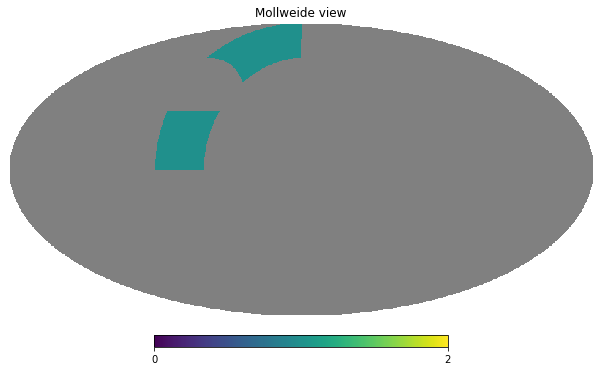

In [17]:
if use_window:
    hp.mollview(zl_bin[0]['window'])

In [18]:
zl_bin[0]['window']

masked_array(data=[1.0, 1.0, 1.0, ..., -1.6375e+30, -1.6375e+30,
                   -1.6375e+30],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-1.6375e+30)

[]

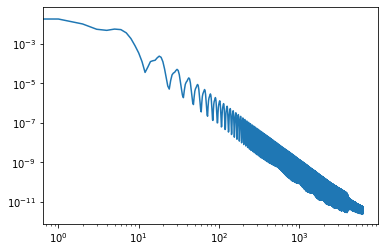

In [19]:
window_cl=hp.anafast(zl_bin[0]['window'])
plt.plot(window_cl)
plt.loglog()

In [85]:
zs_bin=cmb_bins_here(l=l, nside = NSIDE)# lensing source bin

In [86]:
store_win=True

In [87]:
f_sky=0.04404143492380778 #FIXME: use the correct value. If you are using window, then this is not very important.

In [88]:
corr_ll=('kappa','kappa')
corr_gg=('galaxy','galaxy')
corr_gl=('galaxy','kappa')
corrs=[corr_ll, corr_gg, corr_gl]

In [66]:
client

Client Scheduler: inproc://10.0.0.147/46973/1 Dashboard: http://10.0.0.147:8787/status,Cluster Workers: 1 Cores: 4 Memory: 150.00 GB


In [89]:
#use all ell
kappa0=Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1)#,
                                       #power_spectra_kwargs={'cosmo_params':cosmo_params})

Tracer utils has tracers:  ['galaxy', 'kappa']
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 2.465
power spectra camb_pk_too_many_z
Win gen: step size 45 924 2049.0 1
wigner_files: {0: '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 5.936622619628906e-05
set window_cl: cl done 0.001249551773071289 2365.902 0.0
Win_cli ('kappa', 'kappa', 0, 0) ('kappa', 'kappa') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 3.2968287467956543 2365.902 0.0
cl+cov bags done 3 0 7.027912139892578
set_window_cl done 50.46301293373108
setting windows, coupling matrices  <Client: 'inproc://10.0.0.147/46973/1' processes=1 threads=4, memory=150.00 GB>
doing lm 0
done lm cl+cov graph 0 0.0010082721710205078 3221.589 inproc://10.0.0.147/46973/3
done lm 0 6.7999141

distributed.semaphore - WARNING - Tried to release semaphore but it was already released: name=database, lease_id=6708f34ae8d842568cae0844d5d64de0. This can happen if the semaphore timed out before.
distributed.semaphore - WARNING - Tried to release semaphore but it was already released: name=database, lease_id=1d7368f5f6564fdb9a17b2d6181c47b8. This can happen if the semaphore timed out before.


got wig3j 0 681.58 (338, 11) 7
got wig3j 45 681.58 (338, 11) 7


distributed.semaphore - WARNING - Tried to release semaphore but it was already released: name=database, lease_id=d002f9fc20cb436fbc1a8ae1a05f88ab. This can happen if the semaphore timed out before.


got wig3j 135 681.58 (338, 11) 7


distributed.semaphore - WARNING - Tried to release semaphore but it was already released: name=database, lease_id=fa69ef1a0ee84efa957b14dd7b179734. This can happen if the semaphore timed out before.


got wig3j 90 681.58 (338, 11) 7
got wig3j 405 681.58 (338, 11) 7
got wig3j 360 681.58 (338, 11) 8
got wig3j 315 681.58 (338, 11) 7
got wig3j 225 681.58 (338, 11) 7
got wig3j 270 681.58 (338, 11) 7
got wig3j 180 681.58 (338, 11) 7
done lm 405 40.83596158027649
doing lm 450
done lm cl+cov graph 450 0.0011608600616455078 3221.585 inproc://10.0.0.147/46973/3
done lm 450 4.510888576507568
doing lm 495
done lm cl+cov graph 495 0.0008921623229980469 3221.585 inproc://10.0.0.147/46973/3
done lm 495 4.376277685165405
doing lm 540
done lm cl+cov graph 540 0.001554250717163086 3221.585 inproc://10.0.0.147/46973/3
done lm 540 4.385271787643433
doing lm 585
done lm cl+cov graph 585 0.001203775405883789 3221.585 inproc://10.0.0.147/46973/3
done lm 585 4.376974582672119
doing lm 630
done lm cl+cov graph 630 0.0021657943725585938 3221.585 inproc://10.0.0.147/46973/3
done lm 630 4.4838268756866455
doing lm 675
done lm cl+cov graph 675 0.0010311603546142578 3221.585 inproc://10.0.0.147/46973/3
done lm 6

distributed.semaphore - WARNING - Tried to release semaphore but it was already released: name=database, lease_id=d432532efb9e4088b810a5a6228ab529. This can happen if the semaphore timed out before.


got wig3j 450 681.58 (338, 11) 8
got wig3j 540 681.58 (338, 11) 7
got wig3j 585 681.58 (338, 11) 7
got wig3j 495 681.58 (338, 11) 7
got wig3j 855 681.58 (338, 11) 7
got wig3j 810 681.58 (338, 11) 7
got wig3j 765 681.58 (338, 11) 7
got wig3j 720 681.58 (338, 11) 8
got wig3j 630 681.58 (338, 11) 7
got wig3j 675 681.58 (338, 11) 7
done lm 855 43.37220549583435
doing lm 900
done lm cl+cov graph 900 0.001226186752319336 3221.581 inproc://10.0.0.147/46973/3
got wig3j 900 363.509 (338, 11) 7
done lm 900 12.575403451919556
Done all lm 12.575613737106323
done combine lm 12.978036165237427
Window done. Size: 34.234


In [90]:
%time cl0G=kappa0.cl_tomo() 

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 22.1 s, sys: 23.7 s, total: 45.7 s
Wall time: 1.97 s


In [69]:
cl0G.keys()

dict_keys(['stack', 'cl_b', 'cov', 'cl', 'pseudo_cl', 'pseudo_cl_b', 'zkernel'])

In [70]:
#dask.visualize(cl0G['stack'])

In [91]:
lb

array([150., 250., 350., 450., 550., 650., 750., 850., 950.])

In [72]:
cl0G['pseudo_cl_b']

{('kappa',
  'kappa'): {(0,
   0): Delayed('bin_cl_func-39101ed5-c4fd-4b12-b990-711d399c0078')},
 ('galaxy',
  'galaxy'): {(0,
   0): Delayed('bin_cl_func-9d97ed0c-c1c8-448b-bbb5-a3c6fe255445')},
 ('galaxy',
  'kappa'): {(0,
   0): Delayed('bin_cl_func-ddc2e242-b4c3-448d-a0d0-d86f08e3b89f')},
 ('kappa',
  'galaxy'): {(0,
   0): Delayed('bin_cl_func-ddc2e242-b4c3-448d-a0d0-d86f08e3b89f')}}

In [93]:
cl0G['cl'][corr_ll][bi].compute()

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [94]:
kappa0.Ang_PS.z 

array([1.00000000e-04, 1.10752332e-04, 1.22660791e-04, 1.35849686e-04,
       1.50456696e-04, 1.66634299e-04, 1.84551372e-04, 2.04394949e-04,
       2.26372173e-04, 2.50712460e-04, 2.77669897e-04, 3.07525886e-04,
       3.40592091e-04, 3.77213683e-04, 4.17772951e-04, 4.62693286e-04,
       5.12443605e-04, 5.67543243e-04, 6.28567378e-04, 6.96153030e-04,
       7.71005715e-04, 8.53906810e-04, 9.45721706e-04, 1.04740884e-03,
       1.16002972e-03, 1.28475997e-03, 1.42290163e-03, 1.57589674e-03,
       1.74534239e-03, 1.93300740e-03, 2.14085077e-03, 2.37104216e-03,
       2.62598448e-03, 2.90833906e-03, 3.22105333e-03, 3.56739168e-03,
       3.95096948e-03, 4.37579084e-03, 4.84629041e-03, 5.36737965e-03,
       5.94449813e-03, 6.58367031e-03, 7.29156841e-03, 8.07558206e-03,
       8.94389546e-03, 9.90557280e-03, 1.09706529e-02, 1.21502539e-02,
       1.34566896e-02, 1.49035975e-02, 1.65060818e-02, 1.82808706e-02,
       2.02464905e-02, 2.24234604e-02, 2.48345053e-02, 2.75047938e-02,
      

In [52]:
cl0G['pseudo_cl_b'][corr_gg][bi].compute()

/home/tkarim/SkyLens/skylens/tracer_utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)


array([3.14595270e-08, 3.52021607e-08, 3.38360188e-08, 3.21574431e-08,
       3.03689056e-08, 2.84736330e-08, 2.64997619e-08, 2.45152352e-08,
       2.26028145e-08, 2.08350493e-08, 1.92585078e-08, 1.78850795e-08,
       1.66871623e-08, 1.55792869e-08, 1.42576839e-08])

In [58]:
kappa0.Win['cl'][corr_ll][bi]['M']

array([[4.28430275e-03, 3.83654127e-03, 2.90716593e-03, ...,
        8.76065139e-07, 8.50038892e-07, 8.45710650e-07],
       [3.87471581e-03, 4.28417361e-03, 3.83661471e-03, ...,
        9.52345046e-07, 8.76782366e-07, 8.41595871e-07],
       [2.96501998e-03, 3.87441387e-03, 4.28408916e-03, ...,
        1.05298170e-06, 9.44060552e-07, 8.65209760e-07],
       ...,
       [2.20977625e-06, 2.37851694e-06, 2.60420353e-06, ...,
        4.28268318e-03, 3.84647031e-03, 2.92301929e-03],
       [2.15258605e-06, 2.19843460e-06, 2.34403327e-06, ...,
        3.86164376e-03, 4.28269022e-03, 3.84650564e-03],
       [2.15004051e-06, 2.11849995e-06, 2.15669360e-06, ...,
        2.94608058e-03, 3.86161962e-03, 4.28269085e-03]])

/home/tkarim/SkyLens/skylens/tracer_utils.py:201: RuntimeWarning: invalid value encountered in less_equal
  x=ddls<=0 #zs<zl
/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
/home/tkarim/SkyLens/skylens/tracer_utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/home/tkarim/SkyLens/skylens/tracer_utils.py:200: RuntimeWarning: divide by zero encountered in true_divide
  sigma_c=1./(ddls*w)
/home/tkarim/SkyLens/skylens/tracer_utils.py:201: RuntimeWarning: invalid value encountered in less_equal
  x=ddls<=0 #zs<zl
/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


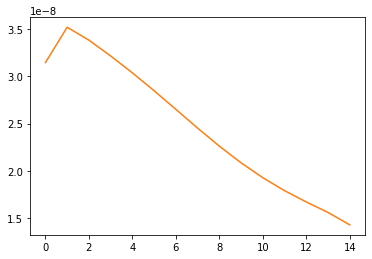

In [50]:
bi=(0,0) #z_bin indexes
plt.plot(cl0G['pseudo_cl_b'][corr_ll][bi].compute())
plt.plot(cl0G['pseudo_cl_b'][corr_gg][bi].compute())
plt.plot(cl0G['pseudo_cl_b'][corr_gl][bi].compute())

In [37]:
cl0G['pseudo_cl_b'][corr_ll][bi].compute()

array([2.82598722e-09, 1.68567360e-09, 1.06196023e-09, 7.44372666e-10,
       5.54079317e-10, 4.28528471e-10, 3.47058241e-10, 2.86486526e-10,
       2.40970358e-10])

Compare with Abacus

In [22]:
cL_abacus = np.array([2.98436168e-09, 1.59208922e-09, 1.02584562e-09, 6.76985059e-10,
       5.34959849e-10, 4.01468676e-10, 3.29359846e-10, 2.69317428e-10,
       2.32066641e-10])

bi=(0,0)
cL_skylens = cl0G['pseudo_cl_b'][corr_ll][bi].compute()
#cov from skylens
cov_skylens = cl0G['cov'][corr_ll+corr_ll][bi+bi].compute()['final_b']

NameError: name 'cl0G' is not defined

In [21]:
plt.figure(figsize = (10,8))
#err = np.sqrt(np.diag(cov_skylens))
#plt.errorbar(lb, cL_abacus, yerr = err, label = 'abacus')
plt.plot(lb, cL_skylens, label = 'skylens')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc= 'best')

NameError: name 'cL_skylens' is not defined

<Figure size 720x576 with 0 Axes>

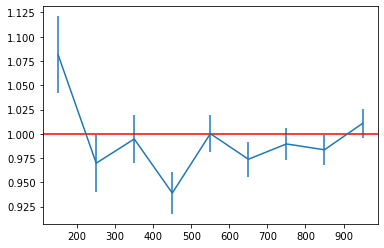

In [29]:
plt.errorbar(lb, cL_abacus/cL_skylens, yerr = err/cL_skylens)
plt.axhline(1, c = 'red')

In [30]:
loss = (cL_abacus - cL_skylens)
inv = np.linalg.inv(cov_skylens)
chi2 = loss @ inv @ loss

In [31]:
chi2

17.679574745241027

In [32]:
corrmat = cov_skylens/np.outer(err, err)

07:10:54 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f52abf9b970>
07:10:54 DEBUG:Using auto colorbar locator on colorbar
07:10:54 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f52abf9b970>
07:10:54 DEBUG:Setting pcolormesh


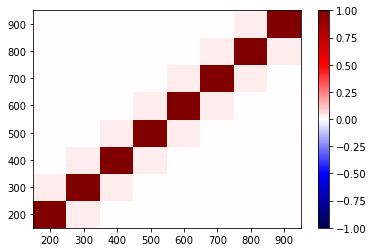

In [33]:
plt.pcolor(lb, lb, corrmat, vmin = -1, vmax = 1, cmap = 'seismic')
plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')